In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import math

In [2]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [3]:
from ipywidgets import IntProgress
from IPython.display import display

**Adicionar fashion_mnist, horses_or_humans, mnist**

In [4]:
url_cat_dog = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
url_flower = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"

zip_cat = tf.keras.utils.get_file('cats_and_dogs.zip', origin=url_cat_dog, extract=True)
zip_flw = tf.keras.utils.get_file('flower_photos.tar', origin=url_flower, extract=True)

path_cat = os.path.join(os.path.dirname(zip_cat), 'cats_and_dogs_filtered')
path_flw = os.path.join(os.path.dirname(zip_flw), 'flower_photos')

In [5]:
BATCH_SIZE = 32
IMG_SIZE = (128, 128)

In [6]:
train_cat = tf.keras.utils.image_dataset_from_directory(os.path.join(path_cat, 'train'), shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE)
valid_cat = tf.keras.utils.image_dataset_from_directory(os.path.join(path_cat, 'validation'), shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE)

train_flw = tf.keras.utils.image_dataset_from_directory(path_flw, validation_split=0.2, subset="training", seed=123, batch_size=BATCH_SIZE, image_size=IMG_SIZE)
valid_flw = tf.keras.utils.image_dataset_from_directory(path_flw, validation_split=0.2, subset="validation", seed=123, batch_size=BATCH_SIZE, image_size=IMG_SIZE)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [7]:
cat_class_names = train_cat.class_names
flw_class_names = train_flw.class_names

# Viz

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_cat.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(cat_class_names[labels[i]])
        plt.axis("off")

plt.show()

plt.figure(figsize=(10, 10))
for images, labels in train_flw.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(flw_class_names[labels[i]])
        plt.axis("off")

# Preprocessing

In [8]:
AUTOTUNE = tf.data.AUTOTUNE

cat_train_ds = train_cat.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
cat_valid_ds = valid_cat.cache().prefetch(buffer_size=AUTOTUNE)

flw_train_ds = train_flw.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
flw_valid_ds = valid_flw.cache().prefetch(buffer_size=AUTOTUNE)

# Model

In [9]:
def generate_model(num_classes):
    data_augmentation = keras.Sequential([
        layers.RandomFlip("horizontal", input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
      ])
    return Sequential([
        data_augmentation,
        layers.Rescaling(1./255),
        layers.Conv2D(16, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(32, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(64, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Dropout(0.2),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(num_classes)
    ])

In [10]:
def print_performance(title, history, epochs):
    acc = history.history['accuracy']
    loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']
    
    print(title, 'acc:', acc[-1], 'val_acc:', val_acc[-1])

    epochs_range = range(epochs)

    plt.figure(figsize=(15, 5))
    plt.suptitle(title)
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

In [11]:
def print_filters_1d(filters):
    depth = filters.shape[-1]
    size = math.ceil(math.sqrt(depth))
    
    if depth < (size*size):
        filters = np.resize(filters, (size*size))
    
    fig, axarr = plt.subplots(1,1, figsize=(size/4, size/4))
    axarr.axis('off')
    axarr.imshow(np.reshape(filters, (size, size)))
    fig.suptitle(filters.shape, fontsize=8)

def print_filters_2d(filters):
    depth = filters.shape[-1]
    mj = filters.shape[-2]
    mi = math.ceil(depth/mj)
    fi = 0
    fig, axarr = plt.subplots(mi, mj, figsize=(20, mi))
    for i in range(mi):
        for j in range(mj):
            axarr[i][j].axis('off')
            if fi < depth:
                axarr[i][j].imshow(filters[:,:,fi,0], cmap='gray')
            fi += 1
    fig.suptitle(filters.shape, fontsize=8)
    
def print_filters_3d(filters):
    depth = filters.shape[-1]
    mj = 16
    mi = math.ceil(depth/mj)
    fi = 0
    fig, axarr = plt.subplots(mi, mj, figsize=(20, mi))
    if mi == 1:
        for j in range(mj):
            axarr[j].axis('off')
            if fi < depth:
                axarr[j].imshow(filters[:,:,fi])
            fi += 1
    else:
        for i in range(mi):
            for j in range(mj):
                axarr[i][j].axis('off')
                if fi < depth:
                    axarr[i][j].imshow(filters[:,:,fi])
                fi += 1
    fig.suptitle(filters.shape, fontsize=8)

In [12]:
def get_mean_weight(model, dataset, neuron_layers):
    pass

def get_mean_output(model, dataset, neuron_layers):
    means = {}
    deviations = {}
    for l in neuron_layers:
        means[l] = None
        deviations[l] = None
    
    f = IntProgress(min=0, max=len(dataset))
    display(f)
    
    for images, labels in dataset:
        for i in range(1, len(images)+1):
            out = images[i-1:i]
            for l in range(len(model.layers)):
                out = model.layers[l](out)
                if l in neuron_layers:
                    if means[l] is None:
                        means[l] = np.copy(out)
                    else:
                        means[l] += out
        f.value += 1

    for l in neuron_layers:
        means[l] = means[l] / len(dataset)
    print('Mean calculated')
        
    f = IntProgress(min=0, max=len(dataset))
    display(f)
    
    for images, labels in dataset:
        for i in range(1, len(images)+1):
            out = images[i-1:i]
            for l in range(len(model.layers)):
                out = model.layers[l](out)
                if l in neuron_layers:
                    if deviations[l] is None:
                        deviations[l] = (out - means[l])**2
                    else:
                        deviations[l] += (out - means[l])**2
        f.value += 1
    
    for l in neuron_layers:
        deviations[l] = np.sqrt(deviations[l] / len(dataset))
    print('Std dev calculated')
    
    return means, deviations

# Training T1, T2

In [ ]:
%%time
epochs=10
model = generate_model(len(flw_class_names))
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
historyt1 = model.fit(train_flw, validation_data=valid_flw, epochs=epochs, verbose=0)
print_performance('T1', historyt1, epochs)

In [ ]:
%%time
epochs=10
model = generate_model(len(cat_class_names))
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
historyt2 = model.fit(train_cat, validation_data=valid_cat, epochs=epochs, verbose=0)
print_performance('T2', historyt1, epochs)

# Join datasets Y

In [13]:
total_label = len(flw_class_names) + len(cat_class_names)
diff_flw = total_label - len(flw_class_names)
diff_cat = total_label - len(cat_class_names)

In [14]:
train_cat_join = train_cat.map(lambda x, y: (x, y + diff_cat))
valid_cat_join = valid_cat.map(lambda x, y: (x, y + diff_cat))

# Training T1 -> T2

In [ ]:
%%time
epochs=10
model = generate_model(total_label)
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
historyt1 = model.fit(train_flw, validation_data=valid_flw, epochs=epochs, verbose=0)
print_performance('T1', historyt1, epochs)

In [ ]:
%%time

losst1, acct1 = model.evaluate(valid_flw)
losst2, acct2 = model.evaluate(valid_cat_join)
print('Pre Train:')
print('T1', 'acc:', acct1, 'loss:', losst1)
print('T2', 'acc:', acct2, 'loss:', losst2)

epochs=10
historyt2 = model.fit(train_cat_join, validation_data=valid_cat_join, epochs=epochs, verbose=0)

losst1, acct1 = model.evaluate(valid_flw)
print('Post Train:')
print('T1', 'acc:', acct1, 'loss:', losst1)

print_performance('T2', historyt2, epochs)

# Sleep

In [15]:
cnn_layers = [2,4,6]
neuron_layers = [10,11]
all_layers = [2,4,6,10,11]

In [59]:
%%time
epochs=10
model = generate_model(total_label)
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
historyt1 = model.fit(train_flw, validation_data=valid_flw, epochs=epochs, verbose=0)

CPU times: total: 13min 14s
Wall time: 3min 55s


In [60]:
%%time
epochs=10
model2 = generate_model(total_label)
model2.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
historyt2 = model2.fit(train_cat_join, validation_data=valid_cat_join, epochs=epochs, verbose=0)

CPU times: total: 9min 26s
Wall time: 2min 51s


In [61]:
%%time
epochs=10
model3 = generate_model(total_label)
model3.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
historyt3 = model3.fit(train_flw, validation_data=valid_flw, epochs=epochs, verbose=0)
historyt32 = model3.fit(train_cat_join, validation_data=valid_cat_join, epochs=epochs, verbose=0)

CPU times: total: 22min 44s
Wall time: 6min 43s


In [62]:
meanst1, deviationst1 = get_mean_output(model, train_flw, neuron_layers)

IntProgress(value=0, max=92)

Mean calculated


IntProgress(value=0, max=92)

Std dev calculated


In [63]:
meanst2, deviationst2 = get_mean_output(model2, train_cat_join, neuron_layers)

IntProgress(value=0, max=63)

Mean calculated


IntProgress(value=0, max=63)

Std dev calculated


In [64]:
meanst31, deviationst31 = get_mean_output(model3, train_flw, neuron_layers)
meanst32, deviationst32 = get_mean_output(model3, train_cat_join, neuron_layers)

IntProgress(value=0, max=92)

Mean calculated


IntProgress(value=0, max=92)

Std dev calculated


IntProgress(value=0, max=63)

Mean calculated


IntProgress(value=0, max=63)

Std dev calculated


(3, 3, 3, 16)
(3, 3, 16, 32)
(3, 3, 32, 64)
(3, 3, 16, 32)
[[-0.10759593 -0.05584408  0.04740174]
 [ 0.04524972 -0.10287233  0.00275661]
 [ 0.06386237  0.03487718 -0.015535  ]]
[[ 3.7684415e-03  1.9558838e-03 -1.6601994e-03]
 [-1.5848270e-03  3.6030018e-03 -9.6547657e-05]
 [-2.2367164e-03 -1.2215389e-03  5.4409803e-04]]


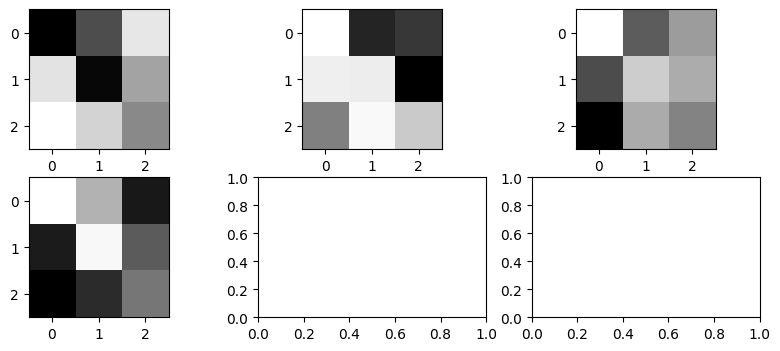

In [25]:
print(model.layers[2].get_weights()[0].shape)
print(model.layers[4].get_weights()[0].shape)
print(model.layers[6].get_weights()[0].shape)

lay = 4

percented = (model.layers[lay].get_weights()[0] / model.layers[lay].get_weights()[0].sum())
print(percented.shape)

print(model.layers[lay].get_weights()[0][:,:,0,0])
print(percented[:,:,0,0])

fig, axarr = plt.subplots(2, 3, figsize=(10, 4))
axarr[0,0].imshow(model.layers[lay].get_weights()[0][:,:,0,0], cmap='gray')
axarr[0,1].imshow(model.layers[lay].get_weights()[0][:,:,1,0], cmap='gray')
axarr[0,2].imshow(model.layers[lay].get_weights()[0][:,:,2,0], cmap='gray')
axarr[1,0].imshow(percented[:,:,0,0], cmap='gray')

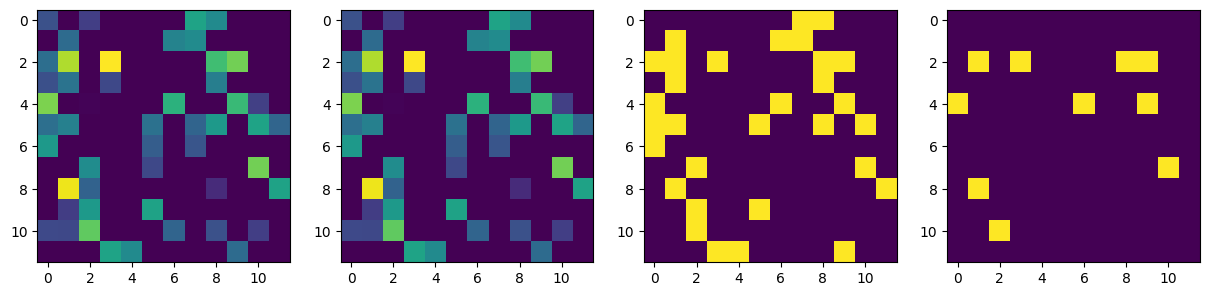

In [23]:
th = 26.29
thpercent = 0.03

fig, axarr = plt.subplots(1, 4, figsize=(15, 4))

mmat = np.reshape(np.resize(meanst1[10][0], (144)), (12, 12))

percented = (meanst1[10][0].numpy() / meanst1[10][0].numpy().sum())
mmat2 = np.reshape(np.resize(percented, (144)), (12, 12))

mmat3 = mmat.copy()
mmat3[mmat <= th] = 0
mmat3[mmat > th] = 1

mmat4 = mmat2.copy()
mmat4[mmat2 <= thpercent] = 0
mmat4[mmat2 > thpercent] = 1

axarr[0].imshow(mmat)
axarr[1].imshow(mmat2)
axarr[2].imshow(mmat3)
axarr[3].imshow(mmat4)

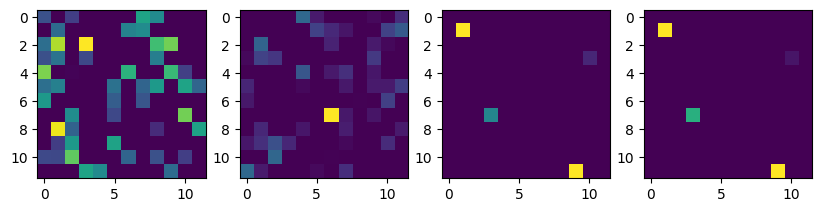

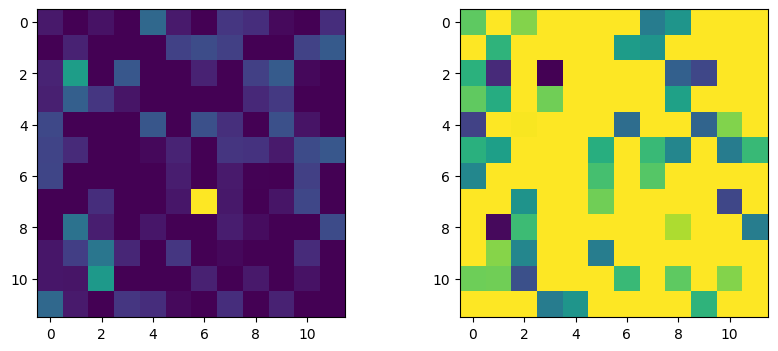

In [24]:
fig, axarr = plt.subplots(1, 4, figsize=(10, 4))
mat1 = np.reshape(np.resize(meanst1[10][0], (144)), (12, 12))
mat2 = np.reshape(np.resize(meanst2[10][0], (144)), (12, 12))
mat3 = np.reshape(np.resize(meanst31[10][0], (144)), (12, 12))
mat4 = np.reshape(np.resize(meanst32[10][0], (144)), (12, 12))
axarr[0].imshow(mat1)
axarr[1].imshow(mat2)
axarr[2].imshow(mat3)
axarr[3].imshow(mat4)
plt.show()

diff_u = mat1 + mat2
diff_mat2 = mat1 * -1
#multpld_mat = np.multiply(mat2, diff_mat)
fig, axarr = plt.subplots(1, 2, figsize=(10, 4))
axarr[0].imshow(diff_u)
axarr[1].imshow(diff_mat2)
plt.show()

In [65]:
meanst1all, _ = get_mean_output(model, train_flw, all_layers)
meanst2all, _ = get_mean_output(model2, train_cat_join, all_layers)

IntProgress(value=0, max=92)

Mean calculated


IntProgress(value=0, max=92)

Std dev calculated


IntProgress(value=0, max=63)

Mean calculated


IntProgress(value=0, max=63)

Std dev calculated


In [63]:
meanst1all[2][0].numpy().shape

(128, 128, 16)

In [76]:
arr = meanst1all[2][0].numpy()
tot = arr.reshape(-1, arr.shape[-1]).sum(axis=0)
med = np.median(tot)
tot > med

array([ True, False, False, False, False,  True, False, False, False,
        True,  True,  True,  True,  True, False,  True])

In [ ]:
for l in cnn_layers:
	print_filters_2d(model.layers[l].get_weights()[0])

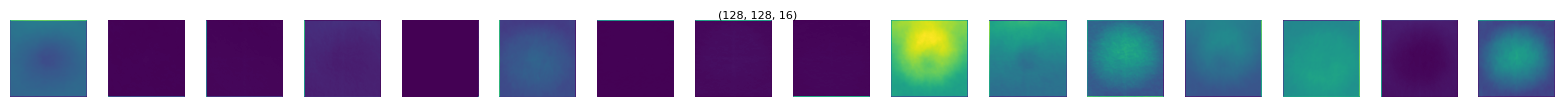

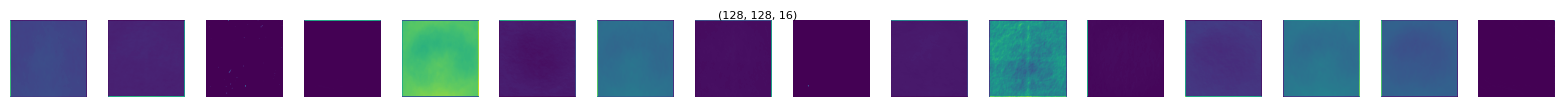

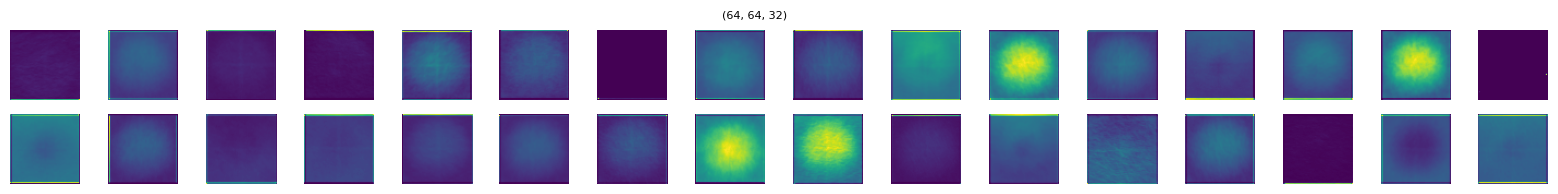

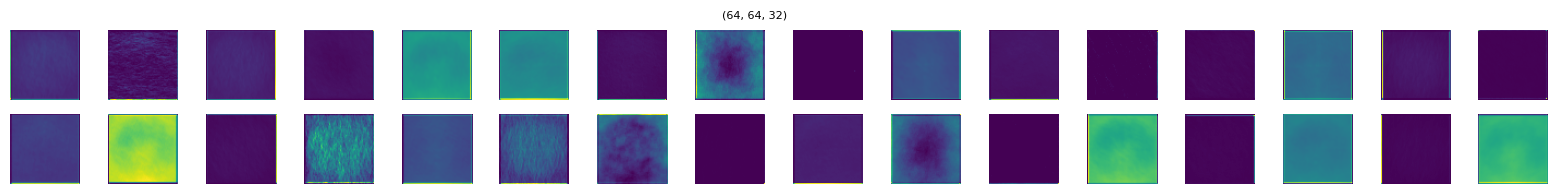

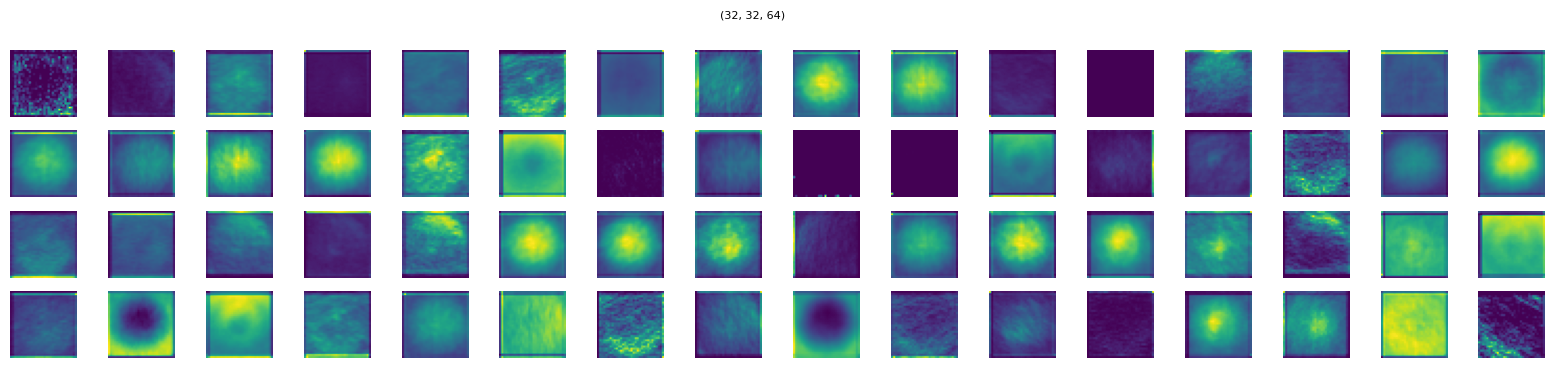

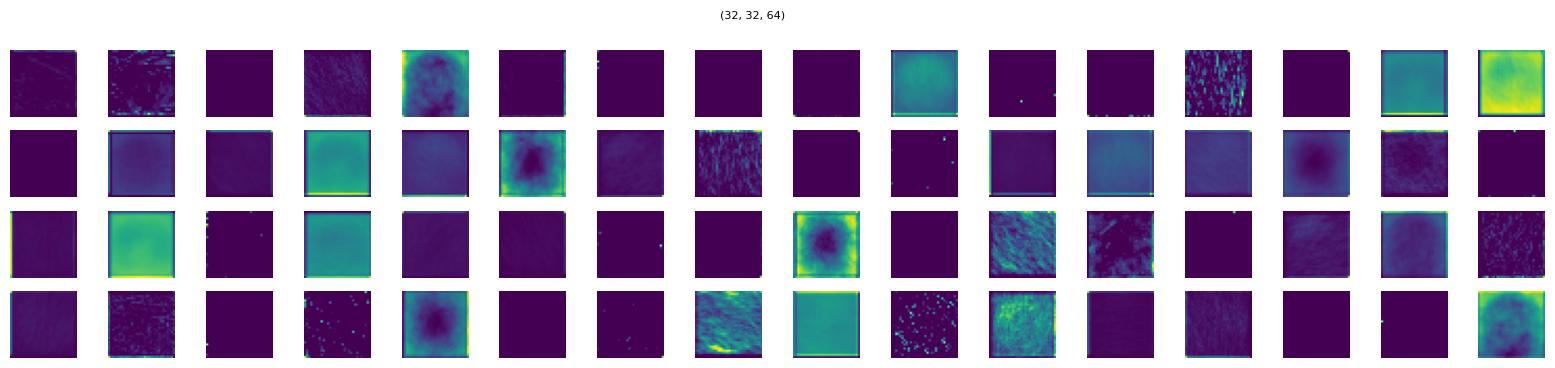

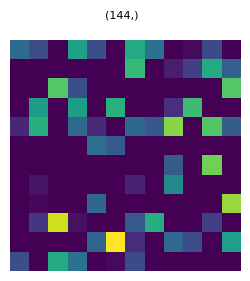

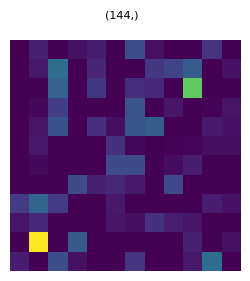

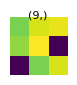

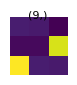

In [40]:
for l in all_layers:
    ftrs = meanst1all[l][0]
    ftrs2 = meanst2all[l][0]
    
    if len(ftrs.shape) == 1:
        print_filters_1d(ftrs)
        print_filters_1d(ftrs2)
    elif len(ftrs.shape) == 3:
        print_filters_3d(ftrs)
        print_filters_3d(ftrs2)

In [56]:
class CustomCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(epoch)
        print(self.model)
        
def custom_evaluate(model, loss, ds_validation):
    loss_avg = tf.keras.metrics.Mean()
    accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
        
    for x, y in ds_validation:
        logits = model(x, training=True)
        loss_value = loss(y, logits)
        
        loss_avg.update_state(loss_value)
        accuracy.update_state(y, logits)
        
    return loss_avg.result().numpy(), accuracy.result().numpy()
                
def custom_training(model, optimizer, loss, ds_train, num_epochs):
    global global_grads
    train_loss_results = []
    train_accuracy_results = []
    
    for epoch in range(num_epochs):
        epoch_loss_avg = tf.keras.metrics.Mean()
        epoch_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

        for x, y in ds_train:
            with tf.GradientTape() as tape:
                logits = model(x, training=True)
                loss_value = loss(y, logits)
            
            grads = tape.gradient(loss_value, model.trainable_weights)
            #global_grads = grads[:]
            
            grads2 = grads[0].numpy()[:]
            grads2[:,:,:,0] = np.zeros((3,3,3))
            grads[0] = tf.convert_to_tensor(grads2)
            
            optimizer.apply_gradients(zip(grads, model.trainable_variables))
            
            epoch_loss_avg.update_state(loss_value)
            epoch_accuracy.update_state(y, logits)
        
        train_loss_results.append(epoch_loss_avg.result())
        train_accuracy_results.append(epoch_accuracy.result())

    return {'loss': train_loss_results, 'accuracy': train_accuracy_results}

In [17]:
global_grads = None

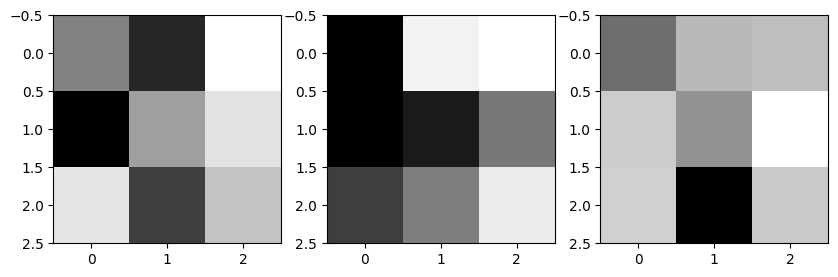

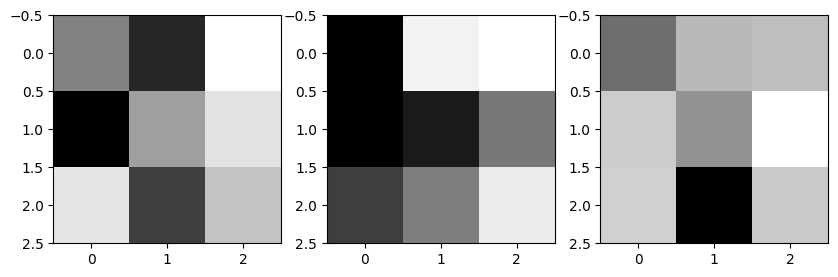

CPU times: total: 9min 59s
Wall time: 3min 43s


In [57]:
%%time
model3 = generate_model(total_label)

fig, axarr = plt.subplots(1, 3, figsize=(10, 4))
axarr[0].imshow(model3.layers[2].get_weights()[0][:,:,0,0], cmap='gray')
axarr[1].imshow(model3.layers[2].get_weights()[0][:,:,1,0], cmap='gray')
axarr[2].imshow(model3.layers[2].get_weights()[0][:,:,2,0], cmap='gray')
plt.show()

opti_fn = tf.keras.optimizers.Adam()
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
history3 = custom_training(model3, opti_fn, loss_fn, train_cat_join, 10)

fig, axarr = plt.subplots(1, 3, figsize=(10, 4))
axarr[0].imshow(model3.layers[2].get_weights()[0][:,:,0,0], cmap='gray')
axarr[1].imshow(model3.layers[2].get_weights()[0][:,:,1,0], cmap='gray')
axarr[2].imshow(model3.layers[2].get_weights()[0][:,:,2,0], cmap='gray')
plt.show()

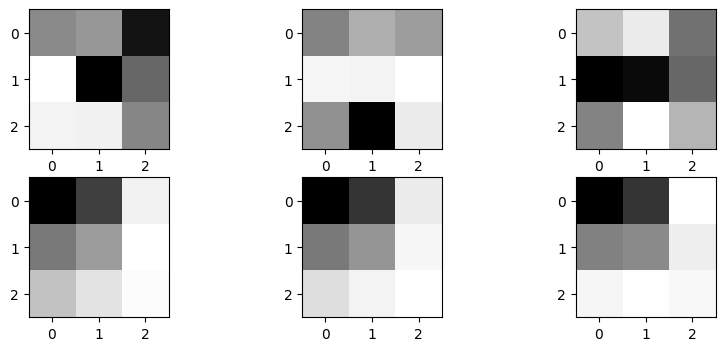

In [20]:
fig, axarr = plt.subplots(2, 3, figsize=(10, 4))
axarr[0,0].imshow(model3.layers[2].get_weights()[0][:,:,0,0], cmap='gray')
axarr[0,1].imshow(model3.layers[2].get_weights()[0][:,:,1,0], cmap='gray')
axarr[0,2].imshow(model3.layers[2].get_weights()[0][:,:,2,0], cmap='gray')
axarr[1,0].imshow(global_grads[0][:,:,0,0], cmap='gray')
axarr[1,1].imshow(global_grads[0][:,:,1,0], cmap='gray')
axarr[1,2].imshow(global_grads[0][:,:,2,0], cmap='gray')

In [53]:
numpys.shape

(3, 3, 3, 16)

In [46]:
global_grads2 = global_grads.copy()
numpys = global_grads2[0].numpy()[:]
numpys[:,:,:,0] = np.zeros((3,3,3))
global_grads2[0] = tf.convert_to_tensor(numpys)

In [ ]:
fig, axarr = plt.subplots(2, 3, figsize=(10, 4))
mat1 = np.reshape(np.resize(meanst1[10][0], (144)), (12, 12))
axarr[0,0].imshow(model3.layers[10].get_weights()[0][:,:,0,0], cmap='gray')
axarr[0,1].imshow(model3.layers[10].get_weights()[0][:,:,1,0], cmap='gray')
axarr[0,2].imshow(model3.layers[10].get_weights()[0][:,:,2,0], cmap='gray')
axarr[1,0].imshow(global_grads[0][:,:,0,0], cmap='gray')
axarr[1,1].imshow(global_grads[0][:,:,1,0], cmap='gray')
axarr[1,2].imshow(global_grads[0][:,:,2,0], cmap='gray')

In [197]:
print(model.evaluate(train_flw))
print(model2.evaluate(train_cat_join))
print(model3.evaluate(train_flw))
print(model3.evaluate(train_cat_join))

92/92 [==============================] - 6s 62ms/step - loss: 0.6674 - accuracy: 0.7527
[0.6673895120620728, 0.7527247667312622]
63/63 [==============================] - 4s 60ms/step - loss: 0.5255 - accuracy: 0.7355
[0.5255239009857178, 0.7354999780654907]
92/92 [==============================] - 6s 63ms/step - loss: 17.6026 - accuracy: 0.0000e+00
[17.60260772705078, 0.0]
63/63 [==============================] - 4s 59ms/step - loss: 0.5974 - accuracy: 0.6825
[0.597402811050415, 0.6825000047683716]


In [ ]:
custom_evaluate(model3, loss_fn, valid_cat_join)

In [ ]:
%%time
epochs=10
model4 = generate_model(total_label)
model4.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
historyt4 = model4.fit(train_cat_join, validation_data=valid_cat_join, epochs=epochs, verbose=0, callbacks=[CustomCallback()])

In [ ]:
model4.evaluate(train_cat_join)